In [ ]:
!pip install yfinance > /dev/null
import yfinance as yf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
import pandas as pd
import numpy as np
import math
from datetime import datetime, date
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
# если продолжаешь работу

import pickle

with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_calls.pickle", 'rb') as msft_file:
  msft_calls = pickle.load(msft_file)
with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_puts.pickle", 'rb') as msft_file:
  msft_puts = pickle.load(msft_file)
with open("/content/drive/MyDrive/Colab Notebooks/sabr/expirations.pickle", 'rb') as msft_file:
  expirations = pickle.load(msft_file)

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [ ]:
# msft_ticker = yf.Ticker('MSFT')
# msft_stock_price = msft_ticker.history().iloc[-1,3]
# expirations = msft_ticker.options
# msft = []

maturities = np.array([
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
])

In [ ]:
strikes = msft_calls[0].strike
for row in msft_calls:
  strikes = np.intersect1d(strikes, row.strike)
set_strikes = set(strikes)
print(len(strikes))

16


In [ ]:
data = []
for row in msft_calls:
  vols = []
  for vol, strike in zip(row.impliedVolatility, row.strike):
    if strike in set_strikes:
      vols.append(vol)
  data.append(vols)
data = np.array(data)

In [ ]:
# если заново загрузил

# msft_calls = []
# msft_puts = []
# for i in range(len(msft)):
#   msft_calls.append(pd.DataFrame(msft[i].calls))
#   msft_puts.append(pd.DataFrame(msft[i].puts))


# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_calls.pickle", 'wb') as msft_file:
#   pickle.dump(msft_calls, msft_file)

# with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_puts.pickle", 'wb') as msft_file:
#   pickle.dump(msft_puts, msft_file)

# with open("/content/drive/MyDrive/Colab Notebooks/sabr/expirations.pickle", 'wb') as msft_file:
#   pickle.dump(expirations, msft_file)

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


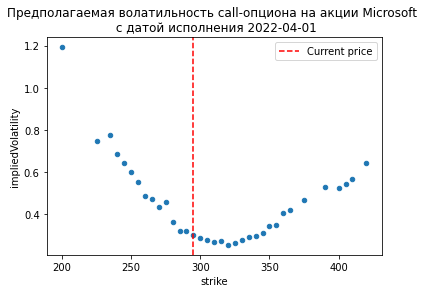

In [ ]:
i = 2
msft_calls[i].plot.scatter(x='strike', y='impliedVolatility');
plt.title(f'Предполагаемая волатильность call-опциона на акции Microsoft \n с датой исполнения {expirations[i]}')
plt.axvline(msft_stock_price, c='red', label='Current price', linestyle='--')
plt.legend();

In [ ]:
tmp = msft_calls[2].copy()
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     35 non-null     object             
 1   lastTradeDate      35 non-null     datetime64[ns, UTC]
 2   strike             35 non-null     float64            
 3   lastPrice          35 non-null     float64            
 4   bid                34 non-null     float64            
 5   ask                35 non-null     float64            
 6   change             35 non-null     float64            
 7   percentChange      35 non-null     float64            
 8   volume             32 non-null     float64            
 9   openInterest       35 non-null     int64              
 10  impliedVolatility  35 non-null     float64            
 11  inTheMoney         35 non-null     bool               
 12  contractSize       35 non-null     object           

In [ ]:
tmp_ = tmp[np.abs(tmp.strike - msft_stock_price) < 12].copy()

In [ ]:
tmp_[['strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility']].to_csv('msft_calls_example.csv')

In [ ]:
msft_calls[i].to_csv('msft_calls.csv')

In [ ]:
def sabr_volatility(K, f, alpha, beta, rho, nu, t):
  z = nu / alpha * (f*K)**((1-beta)/2) * math.log(f/K)
  x = math.log(((1-2*rho*z+z**2)**0.5 + z - rho)/(1-rho))
  first = alpha / ((f*K)**((1-beta)/2) * (1+(1-beta)**2 / 24 * 
          (math.log(f/K))**2 + (1-beta)**4 / 1920 * (math.log(f/K))**4))
  second = z/x
  third = 1 + t*((1-beta)**2 / 24 *  alpha**2 / ((f*K)**(1-beta)) + 
          (rho*beta*nu*alpha)/(4*(f*K)**((1-beta)/2)) + nu**2*(2-3*rho**2)/24)
  return first * second * third

def RSS(par, K, f, t_ex, mrkt):
  strikes = np.array(K)
  mrkt_vols = np.array(mrkt)
  args = {'f' : f, 
          'alpha' : par[0],
          'beta' : par[1],
          'rho' : par[2],
          'nu' : par[3],
          't' : t_ex}
  vect_sabr = np.vectorize(sabr_volatility)
  sabr_vols = np.apply_along_axis(vect_sabr, axis=0, arr=strikes, **args)
  return np.sum(np.square(sabr_vols - mrkt_vols))

## Кривая волатильности для одной даты исполнения. Опцион CALL

Best parameters:
 alpha = 0.2859
 beta = 0.9929
 rho = -0.5975
 nu = 5.3480



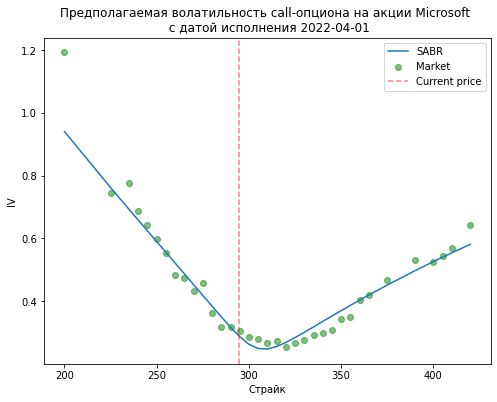

In [ ]:
i = 2
strikes = np.array(msft_calls[i].strike)
nearest = np.argmin(np.abs(strikes-msft_stock_price))
relevant = np.repeat(False, len(strikes))
rel = int(0.175 * len(strikes))
relevant[nearest-rel:] = True
mrkt_vols = np.array(msft_calls[i].impliedVolatility)

min_args_c = (strikes[relevant], msft_stock_price, maturities[i], mrkt_vols[relevant])
x0 = [0.001, 0, -0.999, 0.001]
bounds = ((0.001,None), (0,1), (-0.999,0.999), (0.001,None))
res_c = minimize(RSS, x0, min_args_c, bounds=bounds)

print(f'Best parameters:\n alpha = {res_c.x[0]:0.4f}\n beta = {res_c.x[1]:0.4f}\n '
      f'rho = {res_c.x[2]:0.4f}\n nu = {res_c.x[3]:0.4f}\n')

args = {'f' : msft_stock_price, 
        'alpha' : res_c.x[0], 
        'beta' : res_c.x[1],
        'rho' : res_c.x[2],
        'nu' : res_c.x[3],
        't' : maturities[i]}

vect_sabr = np.vectorize(sabr_volatility)
sabr_vols = np.apply_along_axis(vect_sabr, axis=0, arr=strikes, **args)

plt.figure(figsize=(8,6))
plt.plot(strikes, sabr_vols, label='SABR')
plt.scatter(strikes, mrkt_vols, c='g', alpha=0.5, label='Market')
plt.axvline(msft_stock_price, c='r', label='Current price', 
            linestyle='--', alpha=0.5)
plt.title(f'Предполагаемая волатильность call-опциона на акции Microsoft'
          f' \n с датой исполнения {expirations[i]}')
plt.xlabel('Страйк')
plt.ylabel('IV')
plt.legend();

In [ ]:
MSE(mrkt_vols, sabr_vols)

0.0026307599208498815

## Кривая волатильности для одной даты исполнения. Опцион PUT

Best parameters:
 alpha = 0.3020
 beta = 1.0000
 rho = 0.1000
 nu = 4.0756



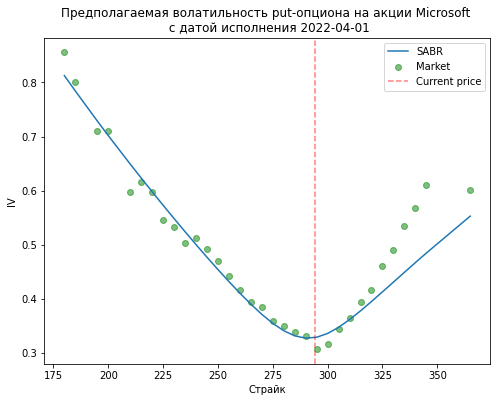

In [ ]:
i = 2
strikes = np.array(msft_puts[i].strike)
nearest = np.argmin(np.abs(strikes-msft_stock_price))
relevant = np.repeat(False, len(strikes))
rel = int(0.175 * len(strikes))
relevant[:nearest+rel] = True
mrkt_vols = np.array(msft_puts[i].impliedVolatility)

min_args_c = (strikes[relevant], msft_stock_price, maturities[i], mrkt_vols[relevant])
x0 = [0.001, 1, -0.999, 0.001]
bounds = ((0.001,None), (1,1), (-0.999,0.999), (0.001,None))
res_c = minimize(RSS, x0, min_args_c, bounds=bounds)

print(f'Best parameters:\n alpha = {res_c.x[0]:0.4f}\n beta = {res_c.x[1]:0.4f}\n '
      f'rho = {res_c.x[2]:0.4f}\n nu = {res_c.x[3]:0.4f}\n')

args = {'f' : msft_stock_price, 
        'alpha' : res_c.x[0], 
        'beta' : res_c.x[1],
        'rho' : res_c.x[2],
        'nu' : res_c.x[3],
        't' : maturities[i]}

vect_sabr = np.vectorize(sabr_volatility)
sabr_vols = np.apply_along_axis(vect_sabr, axis=0, arr=strikes, **args)

plt.figure(figsize=(8,6))
plt.plot(strikes, sabr_vols, label='SABR')
plt.scatter(strikes, mrkt_vols, c='g', alpha=0.5, label='Market')
plt.axvline(msft_stock_price, c='r', label='Current price', 
            linestyle='--', alpha=0.5)
plt.title(f'Предполагаемая волатильность put-опциона на акции Microsoft'
          f' \n с датой исполнения {expirations[i]}')
plt.xlabel('Страйк')
plt.ylabel('IV')
plt.legend();

In [ ]:
MSE(mrkt_vols, sabr_vols)

0.001554262947748624

## Поверхность волатильности для опционов CALL

In [ ]:
all_strikes = msft_calls[0].strike
volatilities_call = np.zeros((len(expirations), len(all_strikes)))
for i in range(len(expirations)):
  strikes = np.array(msft_calls[i].strike)
  nearest = np.argmin(np.abs(strikes-msft_stock_price))
  relevant = np.repeat(False, len(strikes))
  rel = int(0.175 * len(strikes))
  relevant[nearest-rel:] = True
  mrkt_vols = np.array(msft_calls[i].impliedVolatility)

  min_args = (strikes[relevant], msft_stock_price, maturities[i], mrkt_vols[relevant])
  x0 = [0.001, 0, -0.999, 0.001]
  bounds = ((0.001,None), (0,1), (-0.999,0.999), (0.001,None))
  res = minimize(RSS, x0, min_args, bounds=bounds)

  args = {'f' : msft_stock_price, 
          'alpha' : res.x[0], 
          'beta' : res.x[1],
          'rho' : res.x[2],
          'nu' : res.x[3],
          't' : maturities[i]}

  vect_sabr = np.vectorize(sabr_volatility)
  volatilities_call[i,:] = np.apply_along_axis(vect_sabr, axis=0, arr=all_strikes, **args)

https://plotly.com/python/3d-surface-plots/

In [ ]:
mat_threshold = np.array(maturities) < 0.5
# mat_threshold = np.repeat(True, len(maturities))
fig = go.Figure(data=[go.Surface(z=volatilities_call[mat_threshold,:], 
                                 x=all_strikes, y=maturities[mat_threshold],
                                 contours = {'x': {'show': True, 'size': 0.001,
                                                   'start': msft_stock_price*0.999, 
                                                   'end': msft_stock_price*1.001,  
                                                   'color' : 'red'}})])

# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))

fig.update_layout(title='SABR surface for call-option', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=30, r=30, b=30, t=60))

fig.update_layout(scene=dict(
                  xaxis_title="Strikes, $",
                  yaxis_title="Maturities, years",
                  zaxis_title="Implied volatilities"))

fig.show()

In [ ]:
mat_threshold = np.array(maturities) < 1
# mat_threshold = np.repeat(True, len(maturities))
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2, subplot_titles=('Market', 'SABR evaluated'),
    specs=[[{'type': 'surface'}, {'type': 'surface'}]])

fig.add_trace(go.Surface(z=data[mat_threshold,:], showscale=False,
                         x=strikes, y=maturities[mat_threshold],
                         contours = {'x': {'show': True, 'size': 0.001,
                                           'start': msft_stock_price*0.999, 
                                           'end': msft_stock_price*1.001,  
                                           'color' : 'red'}}),
              row=1, col=1)

fig.add_trace(go.Surface(z=volatilities_call[:, all_strikes.isin(strikes).values][mat_threshold], showscale=False,
                         x=strikes, y=maturities[mat_threshold],
                         contours = {'x': {'show': True, 'size': 0.001,
                                           'start': msft_stock_price*0.999, 
                                           'end': msft_stock_price*1.001,  
                                           'color' : 'red'}}),
              row=1, col=2)

fig.update_layout(width=1100, height=600,
                  margin=dict(l=30, r=30, b=30, t=30))

fig.update_scenes(xaxis_title_text="Strikes, $",
                  yaxis_title_text="Maturities, y",
                  zaxis_title_text="IV")
fig.show()

In [ ]:
pred = volatilities_call[:, all_strikes.isin(strikes).values][mat_threshold]
mrkt = data[mat_threshold,:]
MSE(mrkt, pred)

0.004406056065182827

## Поверхность волатильности для опционов PUT

In [ ]:
all_strikes = msft_puts[0].strike
volatilities_put = np.zeros((len(expirations), len(all_strikes)))
for i in range(len(expirations)):
  strikes = np.array(msft_puts[i].strike)
  nearest = np.argmin(np.abs(strikes-msft_stock_price))
  relevant = np.repeat(False, len(strikes))
  rel = int(0.175 * len(strikes))
  relevant[:nearest+rel] = True
  mrkt_vols = np.array(msft_puts[i].impliedVolatility)

  min_args = (strikes[relevant], msft_stock_price, maturities[i], mrkt_vols[relevant])
  x0 = [0.001, 0, -0.999, 0.001]
  bounds = ((0.001,None), (0,1), (-0.999,0.999), (0.001,None))
  res = minimize(RSS, x0, min_args, bounds=bounds)

  args = {'f' : msft_stock_price, 
          'alpha' : res.x[0], 
          'beta' : res.x[1],
          'rho' : res.x[2],
          'nu' : res.x[3],
          't' : maturities[i]}

  vect_sabr = np.vectorize(sabr_volatility)
  volatilities_put[i,:] = np.apply_along_axis(vect_sabr, axis=0, arr=all_strikes, **args)

https://plotly.com/python/3d-surface-plots/

In [ ]:
mat_threshold = np.array(maturities) < 0.5
# mat_threshold = np.repeat(True, len(maturities))
fig = go.Figure(data=[go.Surface(z=volatilities_put[mat_threshold,:], 
                                 x=all_strikes, y=maturities[mat_threshold],
                                 contours = {'x': {'show': True, 'size': 0.01,
                                                   'start': msft_stock_price*0.999, 
                                                   'end': msft_stock_price*1.001,  
                                                   'color' : 'red'}})])

# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))

fig.update_layout(title='SABR surface for put-option', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=30, r=30, b=30, t=60))

fig.update_layout(scene=dict(
                  xaxis_title="Strikes, $",
                  yaxis_title="Maturities, years",
                  zaxis_title="Implied volatilities"))

fig.show()